#Setup
Import libraries and data

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import seaborn as sns

In [2]:
# run this if you are using colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# if this does not run, change to the file path where ALL is located on your device
!unzip gdrive/MyDrive/ALL.zip

Streaming output truncated to the last 5000 lines.
  inflating: ALL/all_pro/all_pro_4792.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_4792.jpg  
  inflating: ALL/all_pro/all_pro_1832.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_1832.jpg  
  inflating: ALL/all_pro/all_pro_0292.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_0292.jpg  
  inflating: ALL/all_pro/all_pro_3943.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_3943.jpg  
  inflating: ALL/all_pro/all_pro_2485.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_2485.jpg  
  inflating: ALL/all_pro/all_pro_3957.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_3957.jpg  
  inflating: ALL/all_pro/all_pro_2491.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_2491.jpg  
  inflating: ALL/all_pro/all_pro_0286.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_0286.jpg  
  inflating: ALL/all_pro/all_pro_1198.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_1198.jpg  
  inflating: ALL/all_pro/all_pro_1826.jpg  
  inflating: _

In [4]:
data_dir = 'ALL'

#Data Processing
Split data into training, validation, and testing sets

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
SEED = 123

full_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

# Get class names from the full dataset before splitting
class_names = full_ds.class_names
num_classes = len(class_names)
print("\nClasses:", class_names)


dataset_size = tf.data.experimental.cardinality(full_ds).numpy()

train_size = int(0.7 * dataset_size)
val_size   = int(0.15 * dataset_size)
test_size  = dataset_size - train_size - val_size  # ensures exact total

train_ds = full_ds.take(train_size)
temp_ds  = full_ds.skip(train_size)

val_ds = temp_ds.take(val_size)
test_ds = temp_ds.skip(val_size)

train_ds = train_ds.shuffle(5000)

print("\nTrain batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())

for i, class_name in enumerate(class_names):
  print(f"Label {i}: {class_name}")

Found 20000 files belonging to 4 classes.

Classes: ['all_benign', 'all_early', 'all_pre', 'all_pro']

Train batches: 437
Val batches: 93
Test batches: 95
Label 0: all_benign
Label 1: all_early
Label 2: all_pre
Label 3: all_pro


In [6]:
for name, ds in [("train", train_ds), ("val", val_ds), ("test", test_ds)]:
    labels = []
    for _, y in ds:
        labels.extend(y.numpy())
    print(name, np.bincount(labels))

train [3493 3497 3514 3480]
val [762 736 753 725]
test [741 760 748 791]


In [7]:
# normalize the data so that values are [0,1] instead of [0,255]
# improves convergence speed and ensures consistency among all features
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [8]:
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels:", labels.numpy()[:50])

unique, counts = np.unique(labels.numpy(), return_counts=True)
print(dict(zip(unique, counts)))

Images shape: (32, 128, 128, 3)
Labels: [1 0 1 2 3 1 1 0 0 0 3 2 0 3 2 1 1 1 0 0 1 3 3 3 0 0 3 1 3 2 3 3]
{np.int32(0): np.int64(9), np.int32(1): np.int64(9), np.int32(2): np.int64(4), np.int32(3): np.int64(10)}


In [9]:
# BEFORE normalization
raw_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle=False,
    image_size=(128, 128),
    batch_size=32
)

for imgs, labs in raw_ds.take(1):
    print("RAW range:", imgs.numpy().min(), imgs.numpy().max())
    break

# AFTER normalization (your actual dataset)
for imgs, labs in train_ds.take(1):
    print("AFTER range:", imgs.numpy().min(), imgs.numpy().max())
    break


Found 20000 files belonging to 4 classes.
RAW range: 0.0 255.0
AFTER range: 0.003921569 1.0


#CNN Models and Training Performance
Model implementation, training, and validation performance visualization


In [10]:
num_classes = 4  # benign, early, pre, pro
epochs = 15

# 2 convolution layers and a max pooling layer
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=IMG_SIZE + (3,)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # multi-class
])

model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

history1 = model1.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stopping])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.5653 - loss: 2.3918 - val_accuracy: 0.8606 - val_loss: 0.3501
Epoch 2/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.8847 - loss: 0.2900 - val_accuracy: 0.8807 - val_loss: 0.2822
Epoch 3/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.9382 - loss: 0.1675 - val_accuracy: 0.8972 - val_loss: 0.2725
Epoch 4/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.9519 - loss: 0.1338 - val_accuracy: 0.9415 - val_loss: 0.1766
Epoch 5/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9824 - loss: 0.0590 - val_accuracy: 0.9237 - val_loss: 0.2033
Epoch 6/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9908 - loss: 0.0301 - val_accuracy: 0.9241 - val_loss: 0.2537
Epoch 7/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.9886 - loss: 0.0359 - val_accuracy: 0.9456 - val_loss: 0.1771
Epoch 8/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.9900 - loss: 0.0314 - 

In [11]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,530,254 (360.60 MB)

 Trainable params: 31,510,084 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,020,170 (240.40 MB)

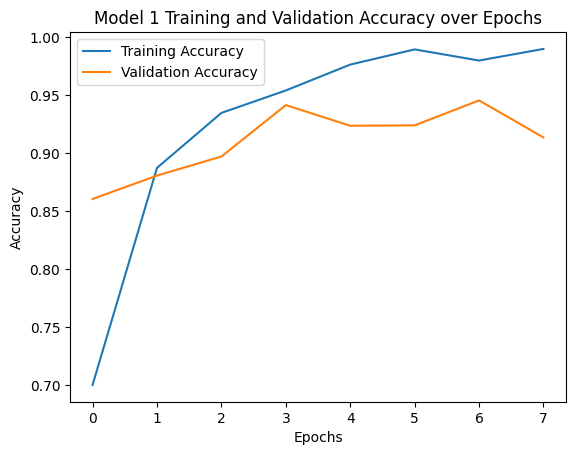

In [12]:
train_acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']
epochs_trained = len(train_acc1)

plt.plot(range(epochs_trained), train_acc1, label='Training Accuracy')
plt.plot(range(epochs_trained), val_acc1, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model 1 Training and Validation Accuracy over Epochs")
plt.legend()
plt.show()

In [13]:
# 2 convolution layers and a max pooling layer and 25% dropout
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=IMG_SIZE + (3,)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # multi-class
])

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

history2 = model2.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stopping])

Epoch 1/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - accuracy: 0.5946 - loss: 1.9131 - val_accuracy: 0.8606 - val_loss: 0.3324
Epoch 2/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.8852 - loss: 0.2810 - val_accuracy: 0.9412 - val_loss: 0.1736
Epoch 3/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.9568 - loss: 0.1231 - val_accuracy: 0.9489 - val_loss: 0.1362
Epoch 4/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.9473 - loss: 0.1382 - val_accuracy: 0.9570 - val_loss: 0.1185
Epoch 5/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.9758 - loss: 0.0788 - val_accuracy: 0.9593 - val_loss: 0.1164
Epoch 6/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.9872 - loss: 0.0376 - val_accuracy: 0.9456 - val_loss: 0.1584
Epoch 7/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.9846 - loss: 0.0443 - val_accuracy: 0.9654 - val_loss: 0.0938
Epoch 8/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9961 - loss: 0.0160 - 

In [14]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,530,254 (360.60 MB)

 Trainable params: 31,510,084 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,020,170 (240.40 MB)

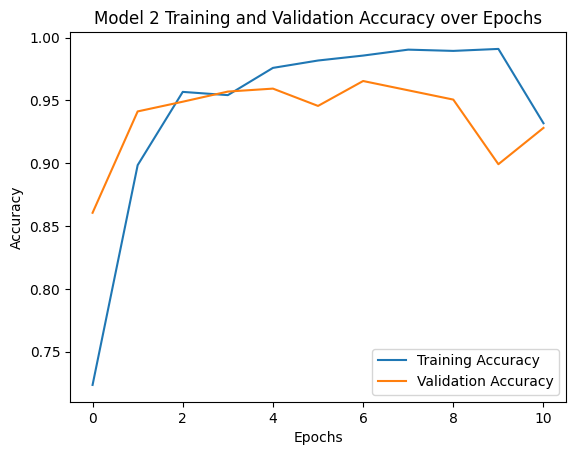

In [15]:
train_acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
epochs_trained = len(train_acc2)

plt.plot(range(epochs_trained), train_acc2, label='Training Accuracy')
plt.plot(range(epochs_trained), val_acc2, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model 2 Training and Validation Accuracy over Epochs")
plt.legend()
plt.show()

# Make Predictions



In [22]:
# Ensure the test dataset is NOT shuffled and not repeated
test_ds_eval = test_ds.cache().prefetch(0)

# Extract true labels in the precise order the model sees them
true_labels = np.array([y.numpy() for _, y in test_ds_eval.unbatch()])

pred_probs_1 = model1.predict(test_ds_eval)
predicted_labels_1 = np.argmax(pred_probs_1, axis=1)

pred_probs_2 = model2.predict(test_ds_eval)
predicted_labels_2 = np.argmax(pred_probs_2, axis=1)

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [23]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

acc1 = accuracy_score(true_labels, predicted_labels_1)
acc2 = accuracy_score(true_labels, predicted_labels_2)

f1_1 = f1_score(true_labels, predicted_labels_1, average="macro")
f1_2 = f1_score(true_labels, predicted_labels_2, average="macro")

print("===== MODEL 1 (No Dropout) =====")
print(f"Accuracy: {acc1:.4f}")
print(f"Macro F1: {f1_1:.4f}")
print(classification_report(true_labels, predicted_labels_1))

print("\n===== MODEL 2 (Dropout) =====")
print(f"Accuracy: {acc2:.4f}")
print(f"Macro F1: {f1_2:.4f}")
print(classification_report(true_labels, predicted_labels_2))


===== MODEL 1 (No Dropout) =====
Accuracy: 0.9069
Macro F1: 0.9056
              precision    recall  f1-score   support

           0       0.90      0.78      0.84       739
           1       0.80      0.92      0.86       759
           2       0.99      0.92      0.95       755
           3       0.95      1.00      0.98       787

    accuracy                           0.91      3040
   macro avg       0.91      0.91      0.91      3040
weighted avg       0.91      0.91      0.91      3040


===== MODEL 2 (Dropout) =====
Accuracy: 0.9197
Macro F1: 0.9185
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       739
           1       0.89      0.85      0.87       759
           2       0.88      0.96      0.92       755
           3       0.97      0.99      0.98       787

    accuracy                           0.92      3040
   macro avg       0.92      0.92      0.92      3040
weighted avg       0.92      0.92      0.92      3040

#Generating and Plotting Confusion Matrices

In [24]:
# Generate confusion matrices for model performance
cm1 = confusion_matrix(true_labels, predicted_labels_1)
cm2 = confusion_matrix(true_labels, predicted_labels_2)

class_names = ["benign", "early", "pre", "pro"]

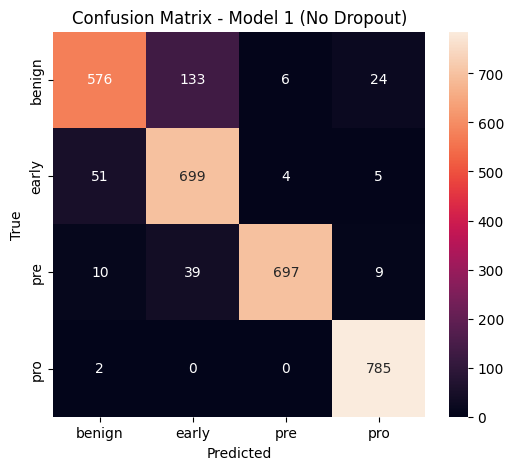

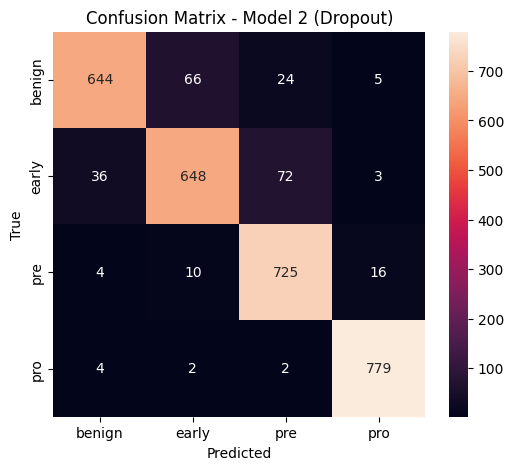

In [26]:
plt.figure(figsize=(6,5))
sns.heatmap(cm1, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Model 1 (No Dropout)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(cm2, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Model 2 (Dropout)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


#Visualizing a CNN layer applied to a single image

In [27]:
# Take one batch from the test dataset
for images, labels in train_ds.take(1):
    # Select the first image from the batch
    sample_image = images[0]
    # Expand dimensions to create a batch of size 1
    sample_image = tf.expand_dims(sample_image, axis=0)

print(sample_image.shape)

(1, 128, 128, 3)


# Extract the output of the convolutional layer
Create a new model that outputs the result of the chosen convolutional layer and apply the filter to the sample image


In [28]:
conv_layer_name = 'conv2d'
feature_map_model = tf.keras.models.Model(inputs=model1.inputs, outputs=model1.get_layer(conv_layer_name).output)
feature_map_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896 (3.50 KB)

 Trainable params: 896 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
feature_maps = feature_map_model.predict(sample_image)
print(feature_maps.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
(1, 126, 126, 32)


##Visualize the generated feature maps

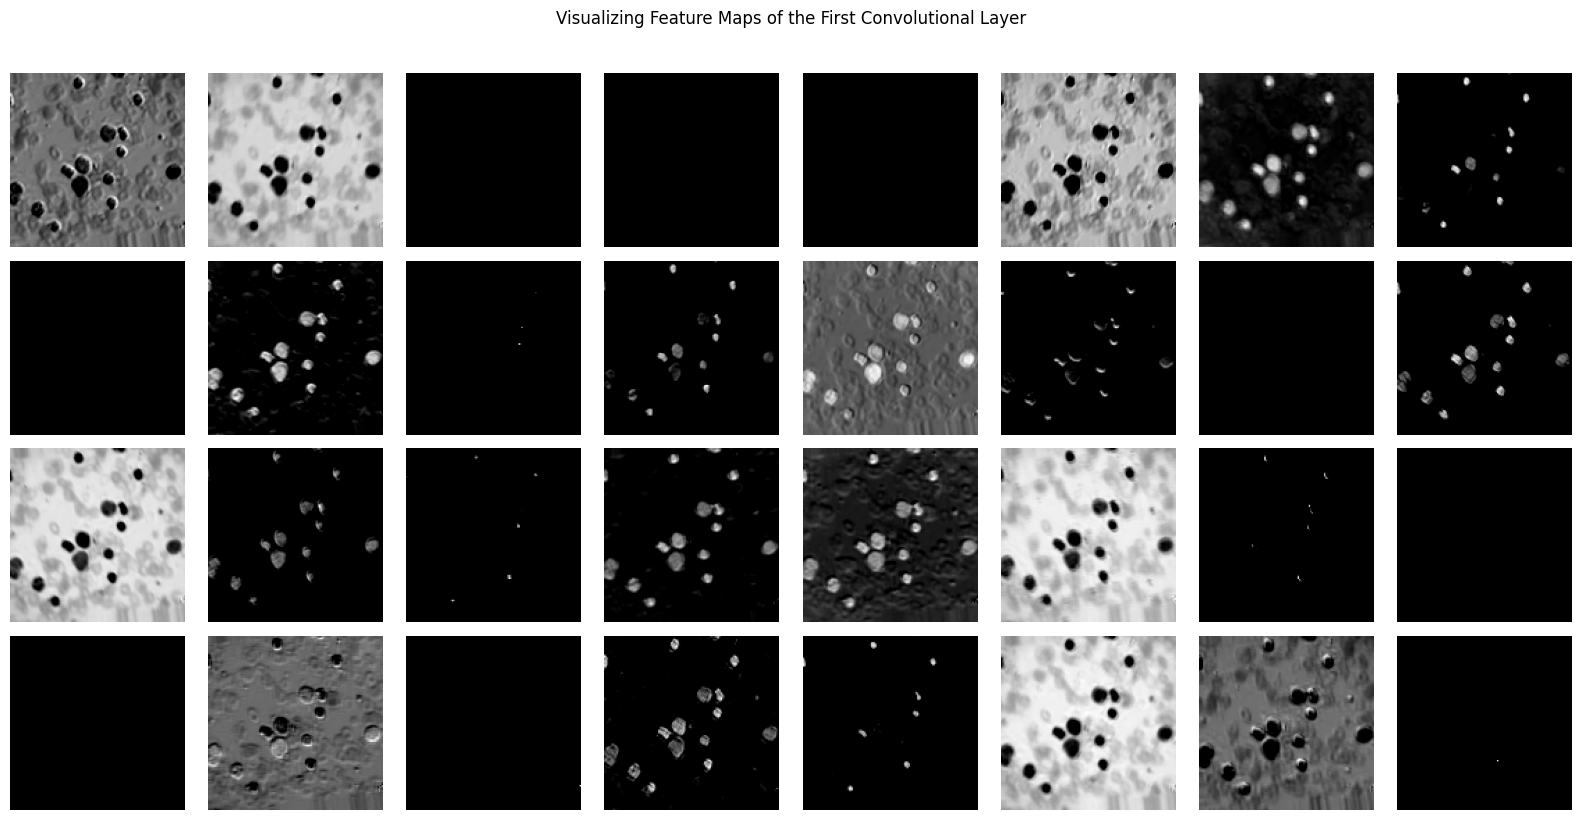

In [30]:
num_feature_maps = feature_maps.shape[-1]
cols = 8
rows = (num_feature_maps + cols - 1) // cols

plt.figure(figsize=(cols * 2, rows * 2))

for i in range(num_feature_maps):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='gray') # Display the i-th feature map
    plt.axis('off')

plt.suptitle("Visualizing Feature Maps of the First Convolutional Layer", y=1.02)
plt.tight_layout()
plt.show()